Experiment No. 3: Natural Language Processing case study for News classification

Name:Ashutosh Kumar Mishra

Roll No:CS7A42

Batch:A2

Sign:

Grade:



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB

In [ ]:
!python -m spacy download en_core_web_sm
import spacy

In [3]:
dataset = pd.read_csv("/content/BBC News Train.csv")
test_set = pd.read_csv("/content/BBC News Test.csv")

In [4]:
dataset.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [5]:
dataset['Text'][0]

'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and practices used by worldcom. mr ebb

In [6]:
dataset.shape

(1490, 3)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [8]:
#count values of given categories
dataset['Category'].value_counts()

sport            346
business         336
politics         274
entertainment    273
tech             261
Name: Category, dtype: int64

In [9]:
#convert categories name into numerical index
# Associate Category names with numerical index and save it in new column CategoryId
target_category = dataset['Category'].unique()
print(target_category)

['business' 'tech' 'politics' 'sport' 'entertainment']


In [10]:
dataset['CategoryId'] = dataset['Category'].factorize()[0]
dataset.head()

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex-boss launches defence lawyers defe...,business,0
1,154,german business confidence slides german busin...,business,0
2,1101,bbc poll indicates economic gloom citizens in ...,business,0
3,1976,lifestyle governs mobile choice faster bett...,tech,1
4,917,enron bosses in $168m payout eighteen former e...,business,0


In [11]:
# Create a new pandas dataframe "category", which only has unique Categories, also sorting this list in order of CategoryId values
category = dataset[['Category', 'CategoryId']].drop_duplicates().sort_values('CategoryId')
category

,Category,CategoryId
0,business,0
3,tech,1
5,politics,2
6,sport,3
7,entertainment,4


In [12]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category.values)
id_to_category = dict(category[['CategoryId', 'Category']].values)
id_to_category

{0: 'business', 1: 'tech', 2: 'politics', 3: 'sport', 4: 'entertainment'}

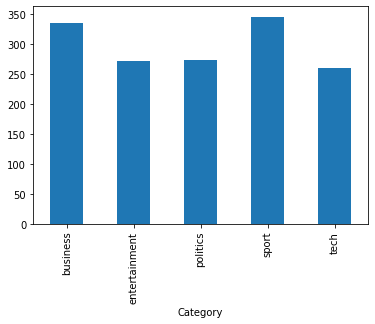

In [13]:
#Visulaizing the category data
dataset.groupby('Category').CategoryId.count().plot.bar(ylim = 0)

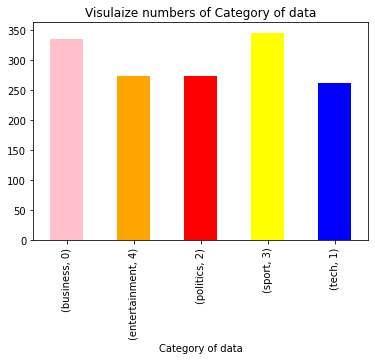

In [14]:
#visualizing category data in numeric form
dataset.groupby('Category').CategoryId.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visulaize numbers of Category of data")
plt.show()

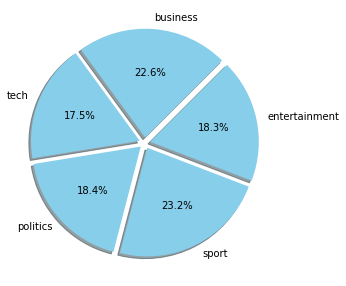

In [15]:
#visualizing category data in percentage form
fig = plt.figure(figsize = (5,5))
colors = ["skyblue"]
business = dataset[dataset['CategoryId'] == 0 ]
tech = dataset[dataset['CategoryId'] == 1 ]
politics = dataset[dataset['CategoryId'] == 2]
sport = dataset[dataset['CategoryId'] == 3]
entertainment = dataset[dataset['CategoryId'] == 4]
count = [business['CategoryId'].count(), tech['CategoryId'].count(), politics['CategoryId'].count(), sport['CategoryId'].count(), entertainment['CategoryId'].count()]
pie = plt.pie(count, labels = ['business', 'tech', 'politics', 'sport', 'entertainment'],
              autopct = "%1.1f%%",
              shadow = True,
              colors = colors,
              startangle = 45,
              explode = (0.05, 0.05, 0.05, 0.05,0.05))

business related words:


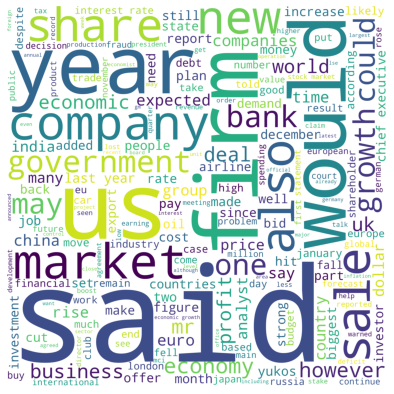

tech related words:


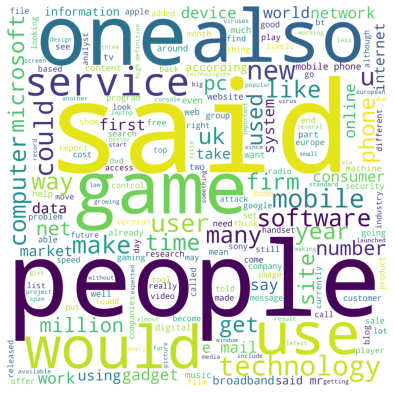

politics related words:


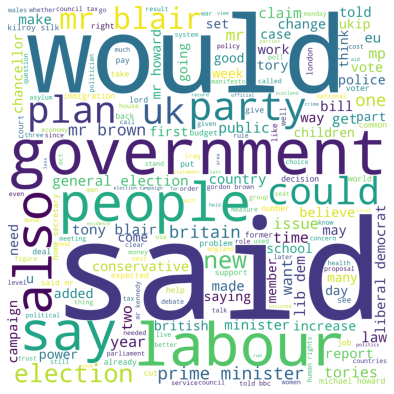

sport related words:


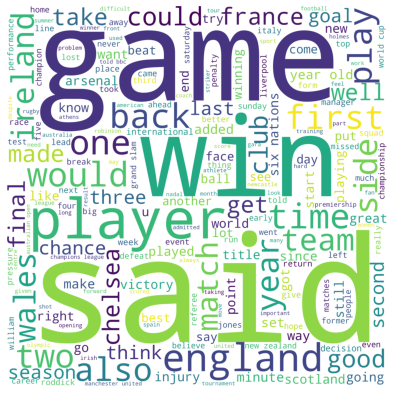

entertainment related words:


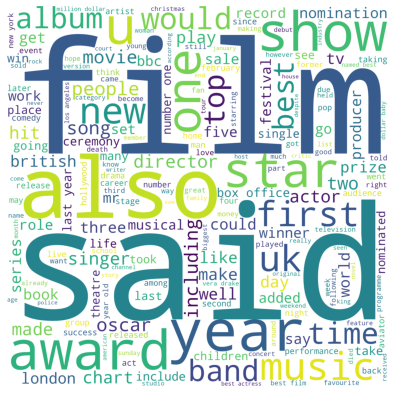

In [16]:
#visualizing category related words
from wordcloud import WordCloud
stop = set(stopwords.words('english'))

business = dataset[dataset['CategoryId'] == 0]
business = business['Text']

tech = dataset[dataset['CategoryId'] == 1]
tech = tech['Text']

politics = dataset[dataset['CategoryId'] == 2]
politics = politics['Text']

sport = dataset[dataset['CategoryId'] == 3]
sport = sport['Text']

entertainment = dataset[dataset['CategoryId'] == 4]
entertainment = entertainment['Text']


def wordcloud_draw(dataset, color = 'white'):
  words = ' '.join(dataset)
  cleaned_word = ' '.join([word for word in words.split()
                           if (word != 'news' and word != 'text')])
  wordcloud = WordCloud(stopwords = stop,
                        background_color = color,
                        width = 2500, height = 2500).generate(cleaned_word)

  plt.figure(1, figsize = (10,7))
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

print("business related words:")
wordcloud_draw(business, 'white')

print("tech related words:")
wordcloud_draw(tech, 'white')

print("politics related words:")
wordcloud_draw(politics, 'white')

print("sport related words:")
wordcloud_draw(sport, 'white')

print("entertainment related words:")
wordcloud_draw(entertainment, 'white')

In [17]:
text = dataset["Text"]
text.head(10)

0    worldcom ex-boss launches defence lawyers defe...
1    german business confidence slides german busin...
2    bbc poll indicates economic gloom citizens in ...
3    lifestyle  governs mobile choice  faster  bett...
4    enron bosses in $168m payout eighteen former e...
5    howard  truanted to play snooker  conservative...
6    wales silent on grand slam talk rhys williams ...
7    french honour for director parker british film...
8    car giant hit by mercedes slump a slump in pro...
9    fockers fuel festive film chart comedy meet th...
Name: Text, dtype: object

In [18]:
category = dataset['Category']
category.head(10)

0         business
1         business
2         business
3             tech
4         business
5         politics
6            sport
7    entertainment
8         business
9    entertainment
Name: Category, dtype: object

# Duplicating dataset for nlp features and deep learning

In [19]:
nlp_features_dataset = dataset

In [20]:
deep_learning_dataset = dataset

In [21]:
def remove_tags(text):
  remove = re.compile(r'<.*?>')
  return re.sub(remove, '', text)

dataset['Text'] = dataset['Text'].apply(remove_tags)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.

In [22]:
def special_char(text):
  reviews = ''
  for x in text:
    if x.isalnum():
      reviews = reviews + x
    else:
      reviews = reviews + ' '
  return reviews

dataset['Text'] = dataset['Text'].apply(special_char)
dataset['Text'][1]


'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [23]:
def convert_lower(text):
   return text.lower()

dataset['Text'] = dataset['Text'].apply(convert_lower)
dataset['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy   munich based research institute ifo said that its confidence index fell to 95 5 in february from 97 5 in january  its first decline in three months  the study found that the outlook in both the manufacturing and retail sectors had worsened  observers had been hoping that a more confident business sector would signal that economic activity was picking up    we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner   the main reason is probably that the domestic economy is still weak  particularly in the retail trade   economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline   he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue   germany s economy grew 1 

In [24]:
def remove_stopwords(text):
  stop_words = set(stopwords.words('english'))
  words = word_tokenize(text)
  return [x for x in words if x not in stop_words]

dataset['Text'] = dataset['Text'].apply(remove_stopwords)
dataset['Text'][1]

['german',
 'business',
 'confidence',
 'slides',
 'german',
 'business',
 'confidence',
 'fell',
 'february',
 'knocking',
 'hopes',
 'speedy',
 'recovery',
 'europe',
 'largest',
 'economy',
 'munich',
 'based',
 'research',
 'institute',
 'ifo',
 'said',
 'confidence',
 'index',
 'fell',
 '95',
 '5',
 'february',
 '97',
 '5',
 'january',
 'first',
 'decline',
 'three',
 'months',
 'study',
 'found',
 'outlook',
 'manufacturing',
 'retail',
 'sectors',
 'worsened',
 'observers',
 'hoping',
 'confident',
 'business',
 'sector',
 'would',
 'signal',
 'economic',
 'activity',
 'picking',
 'surprised',
 'ifo',
 'index',
 'taken',
 'knock',
 'said',
 'dz',
 'bank',
 'economist',
 'bernd',
 'weidensteiner',
 'main',
 'reason',
 'probably',
 'domestic',
 'economy',
 'still',
 'weak',
 'particularly',
 'retail',
 'trade',
 'economy',
 'labour',
 'minister',
 'wolfgang',
 'clement',
 'called',
 'dip',
 'february',
 'ifo',
 'confidence',
 'figure',
 'mild',
 'decline',
 'said',
 'despite',
 'r

In [25]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [26]:
def lemmatize_word(text):
  wordnet = WordNetLemmatizer()
  return " ".join([wordnet.lemmatize(word) for word in text])

dataset['Text'] = dataset['Text'].apply(lemmatize_word)
dataset['Text'][1]

'german business confidence slide german business confidence fell february knocking hope speedy recovery europe largest economy munich based research institute ifo said confidence index fell 95 5 february 97 5 january first decline three month study found outlook manufacturing retail sector worsened observer hoping confident business sector would signal economic activity picking surprised ifo index taken knock said dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement called dip february ifo confidence figure mild decline said despite retreat index remained relatively high level expected modest economic upswing continue germany economy grew 1 6 last year shrinking 2003 however economy contracted 0 2 last three month 2004 mainly due reluctance consumer spend latest indication growth still proving elusive ifo president han werner sinn said improvement german domestic demand sluggish export

In [27]:
#preprocessed dataset
dataset

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex bos launch defence lawyer defendin...,business,0
1,154,german business confidence slide german busine...,business,0
2,1101,bbc poll indicates economic gloom citizen majo...,business,0
3,1976,lifestyle governs mobile choice faster better ...,tech,1
4,917,enron boss 168m payout eighteen former enron d...,business,0
...,...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment,4
1487,1590,weak dollar hit reuters revenue medium group r...,business,0
1488,1587,apple ipod family expands market apple expande...,tech,1


In [28]:
x = dataset['Text']
y = dataset['Category']

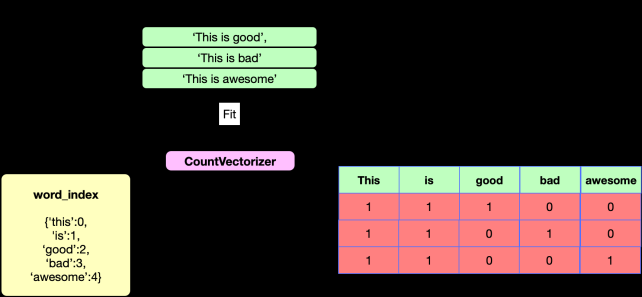

It is a simple and flexible way of extracting features from documents. A Countvectorizer model is a representation of text that describes the occurrence of words within a document. We just keep track of word counts and disregard the grammatical details and the word order. It is called a “bag of words” because any information about the order or structure of words in the document is discarded. The model is only concerned with whether known words occur in the document, not wherein the document.

In [29]:
#create and fit bag of words model

from sklearn.feature_extraction.text import CountVectorizer

x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)

cv = CountVectorizer(max_features = 5000)
x = cv.fit_transform(dataset.Text).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 5000)
y.shape =  (1490,)


In [30]:
x[0]

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
y[0]

0

In [32]:
# view token vocabulary and counts

print("vocabulary", cv.vocabulary_)

print("shape", x.shape)

print("vectors:", x)

vocabulary {'worldcom': 4954, 'ex': 1667, 'bos': 671, 'launch': 2616, 'defence': 1280, 'lawyer': 2622, 'defending': 1284, 'former': 1897, 'chief': 893, 'ebbers': 1507, 'battery': 540, 'fraud': 1924, 'charge': 869, 'called': 763, 'company': 1004, 'first': 1845, 'witness': 4938, 'cooper': 1128, 'head': 2150, 'internal': 2406, 'accounting': 196, 'director': 1374, 'practice': 3413, 'telecom': 4496, 'giant': 2012, '2002': 59, 'warning': 4853, 'led': 2640, 'collapse': 965, 'firm': 1843, 'following': 1876, 'discovery': 1389, '11bn': 12, '7bn': 152, 'mr': 2992, 'pleaded': 3353, 'guilty': 2094, 'conspiracy': 1070, 'prosecution': 3515, 'argued': 402, 'series': 4018, 'trick': 4646, 'employee': 1571, 'hide': 2187, 'expense': 1700, 'revenue': 3808, 'meet': 2859, 'wall': 4840, 'street': 4320, 'earnings': 1495, 'estimate': 1638, 'run': 3881, 'consulting': 1081, 'business': 743, 'told': 4579, 'jury': 2519, 'new': 3061, 'york': 4986, 'wednesday': 4878, 'external': 1728, 'auditor': 469, 'approved': 389,

In [33]:
#train test and split the dataset into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)


print(len(x_train))
print(len(x_test))

1043
447


In [34]:
x_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [35]:
x_test

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
y_train

array([3, 1, 3, ..., 4, 0, 1])

In [37]:
y_test

array([4, 2, 3, 2, 3, 0, 0, 1, 4, 0, 3, 4, 2, 1, 3, 1, 0, 4, 0, 4, 1, 1,
       4, 1, 0, 0, 2, 3, 4, 1, 4, 3, 4, 4, 4, 0, 0, 0, 0, 1, 3, 0, 2, 0,
       3, 4, 3, 4, 1, 3, 2, 3, 4, 3, 3, 4, 4, 4, 3, 4, 3, 1, 3, 0, 3, 1,
       0, 1, 0, 4, 3, 3, 4, 1, 1, 2, 2, 2, 4, 1, 1, 1, 4, 4, 1, 3, 1, 0,
       0, 0, 0, 0, 3, 4, 2, 3, 0, 1, 4, 2, 4, 0, 0, 3, 2, 0, 3, 1, 2, 0,
       4, 4, 2, 2, 4, 4, 4, 4, 1, 2, 2, 0, 2, 3, 4, 1, 3, 3, 3, 3, 3, 3,
       0, 2, 2, 3, 3, 1, 3, 2, 0, 3, 2, 0, 4, 0, 1, 4, 2, 1, 3, 3, 3, 2,
       3, 3, 0, 4, 4, 0, 4, 0, 3, 0, 3, 3, 0, 2, 3, 0, 0, 4, 3, 4, 0, 4,
       1, 2, 0, 4, 1, 1, 1, 2, 1, 3, 0, 0, 4, 3, 2, 4, 2, 1, 0, 2, 2, 3,
       4, 2, 0, 3, 1, 2, 3, 0, 3, 4, 0, 1, 4, 0, 0, 1, 0, 2, 1, 4, 3, 2,
       4, 4, 1, 2, 0, 0, 2, 1, 4, 3, 3, 2, 2, 1, 2, 1, 4, 4, 1, 2, 4, 0,
       3, 3, 3, 1, 0, 2, 4, 2, 0, 1, 1, 0, 2, 3, 2, 2, 0, 4, 0, 1, 3, 1,
       3, 0, 0, 0, 1, 2, 2, 2, 0, 1, 2, 3, 2, 1, 4, 1, 0, 1, 2, 4, 4, 3,
       3, 0, 0, 4, 1, 4, 3, 3, 1, 4, 4, 2, 1, 1, 4,

In [38]:
#create list of model and accuracy dicts
perform_list = []

In [39]:
#create, fit and predict all Machine learning model
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
   


    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [40]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 97.09
Precision : 0.970917225950783
Recall    : 0.970917225950783
F1-score   : 0.9709172259507831


In [41]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 97.99
Precision : 0.9798657718120806
Recall    : 0.9798657718120806
F1-score   : 0.9798657718120806


In [42]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.09
Precision : 0.970917225950783
Recall    : 0.970917225950783
F1-score   : 0.9709172259507831


In [43]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Support Vector Classifer: % 96.64
Precision : 0.9664429530201343
Recall    : 0.9664429530201343
F1-score   : 0.9664429530201343


In [44]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Decision Tree Classifier: % 82.77
Precision : 0.8277404921700223
Recall    : 0.8277404921700223
F1-score   : 0.8277404921700223


In [45]:
#run_model('K Nearest Neighbour', est_c=None, est_pnlty=None)

In [46]:
run_model('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Gaussian Naive Bayes: % 76.06
Precision : 0.7606263982102909
Recall    : 0.7606263982102909
F1-score   : 0.7606263982102909


In [47]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,97.09,0.97,0.97,0.97
1,Random Forest,97.99,0.98,0.98,0.98
2,Multinomial Naive Bayes,97.09,0.97,0.97,0.97
3,Support Vector Classifer,96.64,0.97,0.97,0.97
4,Decision Tree Classifier,82.77,0.83,0.83,0.83
5,Gaussian Naive Bayes,76.06,0.76,0.76,0.76


In [48]:
model = model_performance["Model"]
max_value = model_performance["Test Accuracy"].max()
print("The best accuracy of model is", max_value,"Random Forest")

The best accuracy of model is 97.99 Random Forest


In [49]:
#Individual train, fit and predict the model

In [50]:
#regression Model
model = LogisticRegression()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
scores = accuracy_score(y_test, y_pred)
print("accuracy of our model is:",scores)
print(classification_report(y_pred, y_test, target_names=target_category))

accuracy of our model is: 0.970917225950783
               precision    recall  f1-score   support

     business       0.98      0.95      0.97       106
         tech       0.95      0.99      0.97        74
     politics       0.91      1.00      0.95        74
        sport       1.00      0.96      0.98       101
entertainment       1.00      0.97      0.98        92

     accuracy                           0.97       447
    macro avg       0.97      0.97      0.97       447
 weighted avg       0.97      0.97      0.97       447



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [51]:
#Naive Bayes Model
gnb,mnb,bnb = GaussianNB(),MultinomialNB(alpha=1.0,fit_prior=True),BernoulliNB(alpha=1.0,fit_prior=True)
gnb.fit(x_train,y_train)
mnb.fit(x_train,y_train)
bnb.fit(x_train,y_train)

ypg = gnb.predict(x_test)
ypm = mnb.predict(x_test)
ypb = bnb.predict(x_test)

print("Gaussian = ",accuracy_score(y_test,ypg))
print("Multinomial = ",accuracy_score(y_test,ypm))
print("Bernoulli = ",accuracy_score(y_test,ypb))

print(classification_report(ypm, y_test, target_names=target_category))

Gaussian =  0.912751677852349
Multinomial =  0.970917225950783
Bernoulli =  0.9507829977628636
               precision    recall  f1-score   support

     business       0.94      0.99      0.97        98
         tech       0.96      0.96      0.96        77
     politics       0.96      0.95      0.96        82
        sport       1.00      1.00      1.00        97
entertainment       0.99      0.95      0.97        93

     accuracy                           0.97       447
    macro avg       0.97      0.97      0.97       447
 weighted avg       0.97      0.97      0.97       447



In [52]:
#Support vector Model
svc = SVC()
svc.fit(x_train,y_train)
y_pred1 = svc.predict(x_test)
print(accuracy_score(y_test,y_pred1))
print(classification_report(y_pred1, y_test, target_names=target_category))

0.9530201342281879
               precision    recall  f1-score   support

     business       0.96      0.94      0.95       105
         tech       0.96      0.85      0.90        87
     politics       0.90      1.00      0.95        73
        sport       0.97      0.98      0.97        96
entertainment       0.97      1.00      0.98        86

     accuracy                           0.95       447
    macro avg       0.95      0.95      0.95       447
 weighted avg       0.95      0.95      0.95       447



In [53]:
#Decision Tree Model
classifier = DecisionTreeClassifier()
classifier.fit(x_train,y_train)
y_pred2 = classifier.predict(x_test)
print(accuracy_score(y_test , y_pred2))
print(classification_report(y_pred2, y_test, target_names=target_category))

0.8523489932885906
               precision    recall  f1-score   support

     business       0.85      0.86      0.86       102
         tech       0.77      0.87      0.81        68
     politics       0.84      0.81      0.82        84
        sport       0.91      0.86      0.88       102
entertainment       0.88      0.86      0.87        91

     accuracy                           0.85       447
    macro avg       0.85      0.85      0.85       447
 weighted avg       0.85      0.85      0.85       447



In [54]:
#Random Tree Model
forest = RandomForestClassifier(n_estimators=10 ,criterion='entropy' , random_state=0)
forest.fit(x_train,y_train)
y_pred3 = forest.predict(x_test)

print(accuracy_score(y_test , y_pred3))
print(classification_report(y_pred3, y_test, target_names=target_category))

0.8948545861297539
               precision    recall  f1-score   support

     business       0.87      0.85      0.86       106
         tech       0.86      0.90      0.88        73
     politics       0.89      0.87      0.88        83
        sport       0.97      0.92      0.94       102
entertainment       0.88      0.94      0.91        83

     accuracy                           0.89       447
    macro avg       0.89      0.90      0.89       447
 weighted avg       0.90      0.89      0.89       447



In [55]:
neighbor = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 3)
neighbor.fit(x_train,y_train)
y_pred4 = neighbor.predict(x_test)
print(accuracy_score(y_test , y_pred4))
print(classification_report(y_pred4, y_test, target_names=target_category))

0.7337807606263982
               precision    recall  f1-score   support

     business       0.75      0.83      0.79        93
         tech       0.51      1.00      0.67        39
     politics       0.69      0.97      0.81        58
        sport       1.00      0.50      0.67       194
entertainment       0.66      0.94      0.78        63

     accuracy                           0.73       447
    macro avg       0.72      0.85      0.74       447
 weighted avg       0.82      0.73      0.73       447



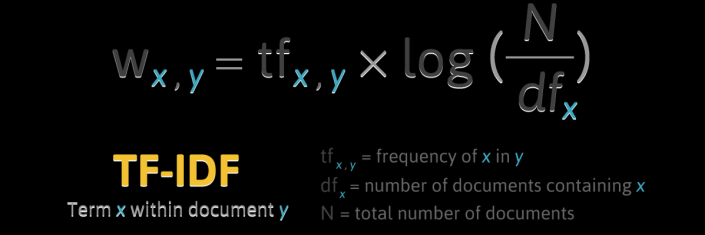

TF-IDF is short for term frequency-inverse document frequency. It’s designed to reflect how important a word is to a document in a collection or corpus.

The TF-IDF value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general.

In [56]:
#tfidf feature

#create and fit bag of words model

from sklearn.feature_extraction.text import TfidfVectorizer

x = np.array(dataset.iloc[:,0].values)
y = np.array(dataset.CategoryId.values)

tf = TfidfVectorizer(max_features = 5000)
x = tf.fit_transform(dataset.Text).toarray()

print("X.shape = ",x.shape)
print("y.shape = ",y.shape)

X.shape =  (1490, 5000)
y.shape =  (1490,)


In [57]:
# convert sparse matrix to numpy array to view

print("Vocabulary", tf.vocabulary_)

print("idf", tf.idf_)

print("Vectors", x)

Vocabulary {'worldcom': 4954, 'ex': 1667, 'bos': 671, 'launch': 2616, 'defence': 1280, 'lawyer': 2622, 'defending': 1284, 'former': 1897, 'chief': 893, 'ebbers': 1507, 'battery': 540, 'fraud': 1924, 'charge': 869, 'called': 763, 'company': 1004, 'first': 1845, 'witness': 4938, 'cooper': 1128, 'head': 2150, 'internal': 2406, 'accounting': 196, 'director': 1374, 'practice': 3413, 'telecom': 4496, 'giant': 2012, '2002': 59, 'warning': 4853, 'led': 2640, 'collapse': 965, 'firm': 1843, 'following': 1876, 'discovery': 1389, '11bn': 12, '7bn': 152, 'mr': 2992, 'pleaded': 3353, 'guilty': 2094, 'conspiracy': 1070, 'prosecution': 3515, 'argued': 402, 'series': 4018, 'trick': 4646, 'employee': 1571, 'hide': 2187, 'expense': 1700, 'revenue': 3808, 'meet': 2859, 'wall': 4840, 'street': 4320, 'earnings': 1495, 'estimate': 1638, 'run': 3881, 'consulting': 1081, 'business': 743, 'told': 4579, 'jury': 2519, 'new': 3061, 'york': 4986, 'wednesday': 4878, 'external': 1728, 'auditor': 469, 'approved': 389,

In [58]:
#train test and split the dataset into training and test set
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0, shuffle = True)


print(len(x_train))
print(len(x_test))

1043
447


In [59]:
#create list of model and accuracy dicts
perform_list = []

In [60]:
#create, fit and predict all Machine learning model
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
   


    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(x_train, y_train)
    y_pred = oneVsRest.predict(x_test)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    print(accuracy)
    # Get precision, recall, f1 scores
    
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))


In [61]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

97.99
Test Accuracy Score of Basic Logistic Regression: % 97.99
Precision : 0.9798657718120806
Recall    : 0.9798657718120806
F1-score   : 0.9798657718120806


In [62]:
run_model('Random Forest', est_c=None, est_pnlty=None)

98.43
Test Accuracy Score of Basic Random Forest: % 98.43
Precision : 0.9843400447427293
Recall    : 0.9843400447427293
F1-score   : 0.9843400447427293


In [63]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

97.54
Test Accuracy Score of Basic Multinomial Naive Bayes: % 97.54
Precision : 0.9753914988814317
Recall    : 0.9753914988814317
F1-score   : 0.9753914988814317


In [64]:
run_model('Support Vector Classifer', est_c=None, est_pnlty=None)

97.54
Test Accuracy Score of Basic Support Vector Classifer: % 97.54
Precision : 0.9753914988814317
Recall    : 0.9753914988814317
F1-score   : 0.9753914988814317


In [65]:
run_model('Decision Tree Classifier', est_c=None, est_pnlty=None)

77.85
Test Accuracy Score of Basic Decision Tree Classifier: % 77.85
Precision : 0.7785234899328859
Recall    : 0.7785234899328859
F1-score   : 0.7785234899328859


In [66]:
#run_model('K Nearest Neighbour', est_c=None, est_pnlty=None)

In [67]:
run_model('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

74.27
Test Accuracy Score of Basic Gaussian Naive Bayes: % 74.27
Precision : 0.7427293064876958
Recall    : 0.7427293064876958
F1-score   : 0.7427293064876959


In [68]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,97.99,0.98,0.98,0.98
1,Random Forest,98.43,0.98,0.98,0.98
2,Multinomial Naive Bayes,97.54,0.98,0.98,0.98
3,Support Vector Classifer,97.54,0.98,0.98,0.98
4,Decision Tree Classifier,77.85,0.78,0.78,0.78
5,Gaussian Naive Bayes,74.27,0.74,0.74,0.74


# Classification using NLP features

In [69]:
#List of features which can be extracted related to text 

In [70]:
nlp_features_dataset

,ArticleId,Text,Category,CategoryId
0,1833,worldcom ex bos launch defence lawyer defendin...,business,0
1,154,german business confidence slide german busine...,business,0
2,1101,bbc poll indicates economic gloom citizen majo...,business,0
3,1976,lifestyle governs mobile choice faster better ...,tech,1
4,917,enron boss 168m payout eighteen former enron d...,business,0
...,...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment,4
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment,4
1487,1590,weak dollar hit reuters revenue medium group r...,business,0
1488,1587,apple ipod family expands market apple expande...,tech,1


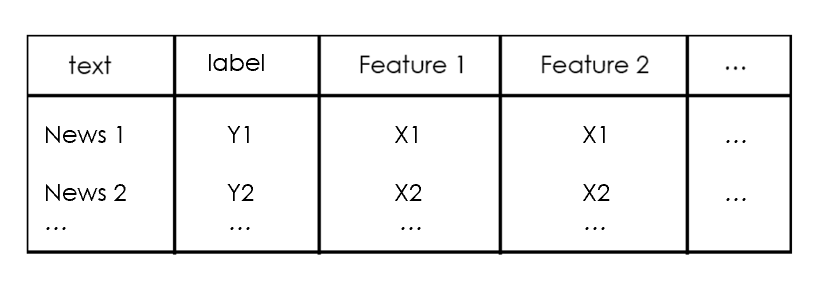

In [71]:
# Number of Characters
#Count the number of characters present in a news.
def count_chars(text):
    return len(text)

In [72]:
#  Number of words

# Count the number of words present in a news.

def count_words(text):
    return len(text.split())

In [73]:
# count number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

In [74]:
#  Number of capital words

# Count the number of capital words present in a tweet.

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

In [75]:
# Count the number of punctuations

# In this function, we return a dictionary of 32 punctuation with the counts, which can be used as separate features, which I will discuss in the next section.

def count_punctuations(text):
    punctuations="!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~"
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

In [76]:
# . Number of words in quotes

# The number of words in the single quotation and double quotation.

def count_words_in_quotes(text):
    x = re.findall("\'.\'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

In [77]:
#  Number of sentences

# Count the number of sentences in a news.

def count_sent(text):
    return len(nltk.sent_tokenize(text))

In [78]:
# count  average sentence length: 
#sum of sentences length divided by the number of sentences (word count/sentence count)

def average_sentence_length(text):
  word_counts = len(text.split())
  sentence_count = len(nltk.sent_tokenize(text))
  return word_counts / sentence_count


In [79]:
from textblob import TextBlob

In [80]:
#TextBlob(x).sentiment.polarity

In [81]:
def sentence_polarity(text):
  if TextBlob(text).sentiment.polarity > 0:
    return 1
  else:
    return 0

In [82]:
#  Count the number of unique words

# Count the number of unique words in a news.

def count_unique_words(text):
    return len(set(text.split()))

In [83]:
# Count of hashtags

#  count the number of times news used the hashtag.

def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

In [84]:
# Count of mentions

# counting the number of mentions can also be treated as a feature.

def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

In [85]:
# Count of stopwords

# Here we will count the number of stopwords used in a news.

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

In [86]:
# stopwords vs words
def stopwords_vs_words(stopwords_cnt,text):
    return stopwords_cnt/len(word_tokenize(text))

In [87]:
#ner spacy example
ner = spacy.load("en_core_web_sm")## tag text
sample_ner_txt = "Will Smith joined Alex to perform for World Cup Song in India"
doc = ner(sample_ner_txt)## display result
spacy.displacy.render(doc,jupyter=True, style="ent")

In [88]:
nlp_features_dataset['char_count'] = nlp_features_dataset["Text"].apply(lambda x:count_chars(x))
nlp_features_dataset['word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_words(x))
nlp_features_dataset['sent_count'] = nlp_features_dataset["Text"].apply(lambda x:count_sent(x))
nlp_features_dataset['capital_char_count'] = nlp_features_dataset["Text"].apply(lambda x:count_capital_chars(x))
nlp_features_dataset['capital_word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_capital_words(x))
nlp_features_dataset['quoted_word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_words_in_quotes(x))
nlp_features_dataset['stopword_count'] = nlp_features_dataset["Text"].apply(lambda x:count_stopwords(x))
nlp_features_dataset['unique_word_count'] = nlp_features_dataset["Text"].apply(lambda x:count_unique_words(x))
nlp_features_dataset['htag_count'] = nlp_features_dataset["Text"].apply(lambda x:count_htags(x))
nlp_features_dataset['mention_count'] = nlp_features_dataset["Text"].apply(lambda x:count_mentions(x))
nlp_features_dataset['punct_count'] = nlp_features_dataset["Text"].apply(lambda x:count_punctuations(x))
nlp_features_dataset['sentiment'] = nlp_features_dataset["Text"].apply(lambda x:sentence_polarity(x))
nlp_features_dataset['avg_wordlength']=nlp_features_dataset['char_count']/nlp_features_dataset['word_count']
nlp_features_dataset['avg_sentlength']=nlp_features_dataset['word_count']/nlp_features_dataset['sent_count']
nlp_features_dataset['unique_vs_words']=nlp_features_dataset['unique_word_count']/nlp_features_dataset['word_count']
nlp_features_dataset['stopwords_vs_words']=nlp_features_dataset['stopword_count']/nlp_features_dataset['word_count']

In [89]:
nlp_features_dataset

,ArticleId,Text,Category,CategoryId,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,sentiment,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
0,1833,worldcom ex bos launch defence lawyer defendin...,business,0,1392,195,1,0,0,0,3,138,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",0,7.138462,195.0,0.707692,0.015385
1,154,german business confidence slide german busine...,business,0,1487,209,1,0,0,0,0,156,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,7.114833,209.0,0.746411,0.000000
2,1101,bbc poll indicates economic gloom citizen majo...,business,0,2091,295,1,0,0,0,0,193,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,7.088136,295.0,0.654237,0.000000
3,1976,lifestyle governs mobile choice faster better ...,tech,1,2341,354,1,0,0,0,0,208,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.612994,354.0,0.587571,0.000000
4,917,enron boss 168m payout eighteen former enron d...,business,0,1553,212,1,0,0,0,0,168,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",0,7.325472,212.0,0.792453,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,857,double eviction big brother model caprice holb...,entertainment,4,868,131,1,0,0,0,0,93,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.625954,131.0,0.709924,0.000000
1486,325,dj double act revamp chart show dj duo jk joel...,entertainment,4,2036,318,1,0,0,0,0,219,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.402516,318.0,0.688679,0.000000
1487,1590,weak dollar hit reuters revenue medium group r...,business,0,983,154,1,0,0,0,0,118,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.383117,154.0,0.766234,0.000000
1488,1587,apple ipod family expands market apple expande...,tech,1,2237,330,1,0,0,0,0,215,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.778788,330.0,0.651515,0.000000


In [90]:
df_punct= pd.DataFrame(list(nlp_features_dataset.punct_count))

In [91]:
df_punct

,! count,""" count",# count,$ count,% count,& count,' count,( count,) count,* count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1486,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1487,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1488,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
# Merging pnctuation DataFrame with main DataFrame
nlp_features_dataset=pd.merge(nlp_features_dataset,df_punct,left_index=True, right_index=True)

In [93]:
nlp_features_dataset.drop(columns=['punct_count'],inplace=True)

In [94]:
nlp_features_dataset.columns

Index(['ArticleId', 'Text', 'Category', 'CategoryId', 'char_count',
       'word_count', 'sent_count', 'capital_char_count', 'capital_word_count',
       'quoted_word_count', 'stopword_count', 'unique_word_count',
       'htag_count', 'mention_count', 'sentiment', 'avg_wordlength',
       'avg_sentlength', 'unique_vs_words', 'stopwords_vs_words', '! count',
       '" count', '# count', '$ count', '% count', '& count', '' count',
       '( count', ') count', '* count', '+ count', ', count', '- count',
       '. count', '/ count', ': count', '; count', '< count', '= count',
       '> count', '? count', '@ count', '[ count', '\ count', '] count',
       '^ count', '_ count', '` count', '{ count', '| count', '} count',
       '~ count'],
      dtype='object')

In [95]:
nlp_ner_df = pd.DataFrame()
nlp_ner_df["tags"] = nlp_features_dataset["Text"].apply(lambda x: [(tag.text, tag.label_) for tag in ner(x).ents] )## utils function to count the element of a list
import collections
def utils_lst_count(lst):
    dic_counter = collections.Counter()
    for x in lst:
        dic_counter[x] += 1
    dic_counter = collections.OrderedDict( 
                     sorted(dic_counter.items(), 
                     key=lambda x: x[1], reverse=True))
    lst_count = [ {key:value} for key,value in dic_counter.items() ]
    return lst_count
## count tags
nlp_ner_df["tags"] = nlp_ner_df["tags"].apply(lambda x: utils_lst_count(x))
## utils function create new column for each tag category
def utils_ner_features(lst_dics_tuples, tag):
    if len(lst_dics_tuples) > 0:
        tag_type = []
        for dic_tuples in lst_dics_tuples:
            for tuple in dic_tuples:
                type, n = tuple[1], dic_tuples[tuple]
                tag_type = tag_type + [type]*n
                dic_counter = collections.Counter()
                for x in tag_type:
                    dic_counter[x] += 1
        return dic_counter[tag]
    else:
        return 0
## extract features
tags_set = []
for lst in nlp_ner_df["tags"].tolist():
     for dic in lst:
          for k in dic.keys():
              tags_set.append(k[1])
tags_set = list(set(tags_set))
for feature in tags_set:
     nlp_ner_df["tags_"+feature] = nlp_ner_df["tags"].apply(lambda x: 
                             utils_ner_features(x, feature))


In [96]:
nlp_ner_df

,tags,tags_ORDINAL,tags_LAW,tags_LOC,tags_PRODUCT,tags_WORK_OF_ART,tags_NORP,tags_GPE,tags_PERSON,tags_ORG,tags_FAC,tags_PERCENT,tags_QUANTITY,tags_CARDINAL,tags_LANGUAGE,tags_EVENT,tags_DATE,tags_MONEY,tags_TIME
0,"[{('worldcom', 'ORG'): 4}, {('cooper', 'PERSON...",0,0,0,0,0,0,1,6,8,0,0,0,0,0,0,9,0,0
1,"[{('german', 'NORP'): 4}, {('germany', 'GPE'):...",1,0,1,0,0,5,3,3,1,0,0,0,3,0,0,5,0,0
2,"[{('bbc', 'ORG'): 4}, {('22', 'CARDINAL'): 2},...",0,0,0,0,0,1,8,1,6,0,0,0,17,0,1,5,0,0
3,"[{('pioneer', 'ORG'): 2}, {('michael bjorn', '...",0,0,0,0,0,2,1,1,3,0,0,0,5,0,0,2,1,0
4,"[{('168', 'CARDINAL'): 3}, {('enron', 'ORG'): ...",2,0,0,0,0,0,2,2,4,0,0,0,12,0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,"[{('4', 'CARDINAL'): 2}, {('holby city', 'GPE'...",2,0,0,0,0,0,1,3,1,0,0,0,5,0,0,5,1,1
1486,"[{('ross', 'PERSON'): 4}, {('1', 'CARDINAL'): ...",0,0,0,0,0,0,0,6,2,0,0,0,11,0,0,6,0,1
1487,"[{('reuters', 'ORG'): 4}, {('11 2004', 'DATE')...",0,0,0,0,0,0,1,0,4,0,0,0,8,0,0,13,0,0
1488,"[{('american', 'NORP'): 2}, {('motorola', 'ORG...",1,0,1,0,0,2,0,2,3,0,0,0,10,0,0,5,0,0


In [97]:
nlp_ner_df.drop(columns=['tags'],inplace=True)

In [98]:
# General Pre-processing 
def remove_links(tweet):
    '''Takes a string and removes web links from it'''
    tweet = re.sub(r'http\S+', '', tweet) # remove http links
    tweet = re.sub(r'bit.ly/\S+', '', tweet) # rempve bitly links
    tweet = tweet.strip('[link]') # remove [links]
    return tweet

def remove_users(tweet):
    '''Takes a string and removes retweet and @user information'''
    tweet = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove retweet
    tweet = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet) # remove tweeted at
    return tweet

my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`{|}~•@'
def preprocess(sent):
    sent = remove_users(sent)
    sent = remove_links(sent)
    sent = sent.lower() # lower case
    sent = re.sub('['+my_punctuation + ']+', ' ', sent) # strip punctuation
    sent = re.sub('\s+', ' ', sent) #remove double spacing
    sent = re.sub('([0-9]+)', '', sent) # remove numbers
    sent_token_list = [word for word in sent.split(' ')]
    sent = ' '.join(sent_token_list)
    return sent

In [99]:
nlp_features_dataset['Text']=nlp_features_dataset['Text'].apply(lambda x: preprocess(x))

In [100]:
nlp_features_dataset.columns

Index(['ArticleId', 'Text', 'Category', 'CategoryId', 'char_count',
       'word_count', 'sent_count', 'capital_char_count', 'capital_word_count',
       'quoted_word_count', 'stopword_count', 'unique_word_count',
       'htag_count', 'mention_count', 'sentiment', 'avg_wordlength',
       'avg_sentlength', 'unique_vs_words', 'stopwords_vs_words', '! count',
       '" count', '# count', '$ count', '% count', '& count', '' count',
       '( count', ') count', '* count', '+ count', ', count', '- count',
       '. count', '/ count', ': count', '; count', '< count', '= count',
       '> count', '? count', '@ count', '[ count', '\ count', '] count',
       '^ count', '_ count', '` count', '{ count', '| count', '} count',
       '~ count'],
      dtype='object')

In [101]:
nlp_features_dataset.drop(columns=['ArticleId'],inplace=True)
nlp_features_dataset.drop(columns=['Category'],inplace=True)

In [102]:
nlp_features_dataset.columns

Index(['Text', 'CategoryId', 'char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'sentiment', 'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count'],
      dtype='object')

In [103]:
nlp_features_dataset=pd.merge(nlp_features_dataset,nlp_ner_df,left_index=True, right_index=True)

In [104]:
nlp_features_dataset.head()

,Text,CategoryId,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,...,tags_ORG,tags_FAC,tags_PERCENT,tags_QUANTITY,tags_CARDINAL,tags_LANGUAGE,tags_EVENT,tags_DATE,tags_MONEY,tags_TIME
0,worldcom ex bos launch defence lawyer defendin...,0,1392,195,1,0,0,0,3,138,...,8,0,0,0,0,0,0,9,0,0
1,german business confidence slide german busine...,0,1487,209,1,0,0,0,0,156,...,1,0,0,0,3,0,0,5,0,0
2,bbc poll indicates economic gloom citizen majo...,0,2091,295,1,0,0,0,0,193,...,6,0,0,0,17,0,1,5,0,0
3,festyle governs mobile choice faster better fu...,1,2341,354,1,0,0,0,0,208,...,3,0,0,0,5,0,0,2,1,0
4,enron boss m payout eighteen former enron dire...,0,1553,212,1,0,0,0,0,168,...,4,0,0,0,12,0,0,5,1,0


In [105]:
nlp_features_dataset.columns

Index(['Text', 'CategoryId', 'char_count', 'word_count', 'sent_count',
       'capital_char_count', 'capital_word_count', 'quoted_word_count',
       'stopword_count', 'unique_word_count', 'htag_count', 'mention_count',
       'sentiment', 'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count', 'tags_ORDINAL', 'tags_LAW',
       'tags_LOC', 'tags_PRODUCT', 'tags_WORK_OF_ART', 'tags_NORP', 'tags_GPE',
       'tags_PERSON', 'tags_ORG', 'tags_FAC', 'tags_PERCENT', 'tags_QUANTITY',
       'tags_CARDINAL', 'tags_LANGUAGE', 'tags_EVENT', 'tags_DATE',
       'tags_MONEY', 'tags_TIME'],

In [106]:
# Getting shape of the df
nlp_features_dataset.shape

(1490, 67)

In [107]:
column_to_move = nlp_features_dataset.pop("CategoryId")

In [108]:
nlp_features_dataset.insert(66, "label_class", column_to_move )

In [109]:
nlp_features_dataset.columns

Index(['Text', 'char_count', 'word_count', 'sent_count', 'capital_char_count',
       'capital_word_count', 'quoted_word_count', 'stopword_count',
       'unique_word_count', 'htag_count', 'mention_count', 'sentiment',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count', 'tags_ORDINAL', 'tags_LAW',
       'tags_LOC', 'tags_PRODUCT', 'tags_WORK_OF_ART', 'tags_NORP', 'tags_GPE',
       'tags_PERSON', 'tags_ORG', 'tags_FAC', 'tags_PERCENT', 'tags_QUANTITY',
       'tags_CARDINAL', 'tags_LANGUAGE', 'tags_EVENT', 'tags_DATE',
       'tags_MONEY', 'tags_TIME', 'label_class']

In [110]:
nlp_feature_labels = nlp_features_dataset['label_class']

In [111]:
nlp_feature_labels[:]

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: label_class, Length: 1490, dtype: int64

In [112]:
nlp_feature_labels

0       0
1       0
2       0
3       1
4       0
       ..
1485    4
1486    4
1487    0
1488    1
1489    1
Name: label_class, Length: 1490, dtype: int64

In [113]:
nlp_features_dataset.drop(columns=['label_class'],inplace=True)

In [114]:
nlp_features_dataset.columns

Index(['Text', 'char_count', 'word_count', 'sent_count', 'capital_char_count',
       'capital_word_count', 'quoted_word_count', 'stopword_count',
       'unique_word_count', 'htag_count', 'mention_count', 'sentiment',
       'avg_wordlength', 'avg_sentlength', 'unique_vs_words',
       'stopwords_vs_words', '! count', '" count', '# count', '$ count',
       '% count', '& count', '' count', '( count', ') count', '* count',
       '+ count', ', count', '- count', '. count', '/ count', ': count',
       '; count', '< count', '= count', '> count', '? count', '@ count',
       '[ count', '\ count', '] count', '^ count', '_ count', '` count',
       '{ count', '| count', '} count', '~ count', 'tags_ORDINAL', 'tags_LAW',
       'tags_LOC', 'tags_PRODUCT', 'tags_WORK_OF_ART', 'tags_NORP', 'tags_GPE',
       'tags_PERSON', 'tags_ORG', 'tags_FAC', 'tags_PERCENT', 'tags_QUANTITY',
       'tags_CARDINAL', 'tags_LANGUAGE', 'tags_EVENT', 'tags_DATE',
       'tags_MONEY', 'tags_TIME'],
      dtype='

In [115]:
nlp_features_dataset_copy = nlp_features_dataset

In [116]:
nlp_features_dataset_copy

,Text,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,...,tags_ORG,tags_FAC,tags_PERCENT,tags_QUANTITY,tags_CARDINAL,tags_LANGUAGE,tags_EVENT,tags_DATE,tags_MONEY,tags_TIME
0,worldcom ex bos launch defence lawyer defendin...,1392,195,1,0,0,0,3,138,0,...,8,0,0,0,0,0,0,9,0,0
1,german business confidence slide german busine...,1487,209,1,0,0,0,0,156,0,...,1,0,0,0,3,0,0,5,0,0
2,bbc poll indicates economic gloom citizen majo...,2091,295,1,0,0,0,0,193,0,...,6,0,0,0,17,0,1,5,0,0
3,festyle governs mobile choice faster better fu...,2341,354,1,0,0,0,0,208,0,...,3,0,0,0,5,0,0,2,1,0
4,enron boss m payout eighteen former enron dire...,1553,212,1,0,0,0,0,168,0,...,4,0,0,0,12,0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,double eviction big brother model caprice holb...,868,131,1,0,0,0,0,93,0,...,1,0,0,0,5,0,0,5,1,1
1486,dj double act revamp chart show dj duo jk joel...,2036,318,1,0,0,0,0,219,0,...,2,0,0,0,11,0,0,6,0,1
1487,weak dollar hit reuters revenue medium group r...,983,154,1,0,0,0,0,118,0,...,4,0,0,0,8,0,0,13,0,0
1488,apple ipod family expands market apple expande...,2237,330,1,0,0,0,0,215,0,...,3,0,0,0,10,0,0,5,0,0


In [117]:
tfn_vectorizer =  TfidfVectorizer()
nlp_features_dataset_copy_tf_idf_features =  tfn_vectorizer.fit_transform(nlp_features_dataset_copy['Text']).toarray()
nlp_features_dataset_copy_tf_idf_features_df  = pd.DataFrame(nlp_features_dataset_copy_tf_idf_features)


In [118]:
nlp_features_dataset_copy_tf_idf_features_df

,0,1,2,3,4,5,6,7,8,9,...,21030,21031,21032,21033,21034,21035,21036,21037,21038,21039
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
nlp_features_dataset_copy.drop(columns=['Text'],inplace=True)

In [120]:
nlp_features_final = pd.merge(nlp_features_dataset_copy_tf_idf_features_df,nlp_features_dataset_copy,left_index=True, right_index=True)

In [121]:
nlp_features_final

,0,1,2,3,4,5,6,7,8,9,...,tags_ORG,tags_FAC,tags_PERCENT,tags_QUANTITY,tags_CARDINAL,tags_LANGUAGE,tags_EVENT,tags_DATE,tags_MONEY,tags_TIME
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8,0,0,0,0,0,0,9,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,3,0,0,5,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6,0,0,0,17,0,1,5,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,0,5,0,0,2,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,0,0,0,12,0,0,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,5,0,0,5,1,1
1486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2,0,0,0,11,0,0,6,0,1
1487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4,0,0,0,8,0,0,13,0,0
1488,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3,0,0,0,10,0,0,5,0,0


In [122]:
train_nlp, val_nlp, train_label, val_label = train_test_split(nlp_features_final,nlp_feature_labels, test_size = 0.3, random_state = 0, shuffle = True)


In [123]:
val_label

9       4
354     2
1227    3
907     2
575     3
       ..
1030    3
892     0
1434    3
431     1
194     3
Name: label_class, Length: 447, dtype: int64

In [124]:
#x = np.array(dataset.iloc[:,0].values)
train_label_ = train_label.to_numpy()
val_label_ = val_label.to_numpy()

#Prediction with NLP features

In [125]:
perform_list_nlp = []

In [126]:
#create, fit and predict all Machine learning model
def run_model_nlp(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100 ,criterion='entropy' , random_state=0)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB(alpha=1.0,fit_prior=True)
    elif model_name == 'Support Vector Classifer':
        mdl = SVC()
    elif model_name == 'Decision Tree Classifier':
        mdl = DecisionTreeClassifier()
    elif model_name == 'K Nearest Neighbour':
        mdl = KNeighborsClassifier(n_neighbors=10 , metric= 'minkowski' , p = 4)
    elif model_name == 'Gaussian Naive Bayes':
        mdl = GaussianNB()
   


    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(train_nlp, train_label_)
    y_pred = oneVsRest.predict(val_nlp)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(val_label_, y_pred) * 100, 2)
    #print(accuracy)
    # Get precision, recall, f1 scores
    
    precision, recall, f1score, support = score(val_label_, y_pred, average='micro')

    #print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    #print(f'Precision : {precision}')
    #print(f'Recall    : {recall}')
    #print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list_nlp.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))


In [158]:
run_model_nlp('Logistic Regression', est_c=None, est_pnlty=None)

run_model_nlp('Random Forest', est_c=None, est_pnlty=None)

run_model_nlp('Multinomial Naive Bayes', est_c=None, est_pnlty=None)


run_model_nlp('Support Vector Classifer', est_c=None, est_pnlty=None)

run_model_nlp('Decision Tree Classifier', est_c=None, est_pnlty=None)

#run_model_nlp('K Nearest Neighbour', est_c=None, est_pnlty=None)

run_model_nlp('Gaussian Naive Bayes', est_c=None, est_pnlty=None)

model_performance_nlp = pd.DataFrame(data=perform_list_nlp)
model_performance_nlp = model_performance_nlp[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]


In [159]:
model_performance_nlp

,Model,Test Accuracy,Precision,Recall,F1
0,Logistic Regression,56.60,0.57,0.57,0.57
1,Random Forest,96.42,0.96,0.96,0.96
2,Multinomial Naive Bayes,49.89,0.50,0.50,0.50
3,Support Vector Classifer,42.51,0.43,0.43,0.43
4,Decision Tree Classifier,78.08,0.78,0.78,0.78
5,Gaussian Naive Bayes,70.02,0.70,0.70,0.70


In [160]:
#individual classifier
model = SVC()
model.fit(train_nlp, train_label_)
y_pred = model.predict(val_nlp)
scores = accuracy_score(val_label_, y_pred)
print("accuracy of our model is:",scores)
print(classification_report(y_pred, y_test, target_names=target_category))


accuracy of our model is: 0.3512304250559284
               precision    recall  f1-score   support

     business       0.62      0.34      0.44       187
         tech       0.22      0.50      0.31        34
     politics       0.42      0.27      0.33       125
        sport       0.43      0.42      0.42       101
entertainment       0.00      0.00      0.00         0

     accuracy                           0.35       447
    macro avg       0.34      0.31      0.30       447
 weighted avg       0.49      0.35      0.40       447



# Deep learning for multiclass text classification

In [ ]:
!pip install chart_studio

In [128]:
import sys
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.graph_objs import *
import plotly.figure_factory as ff
import chart_studio
import chart_studio.plotly as py

# to avoid warnings 
import warnings
warnings.filterwarnings("ignore")

# text processing
import nltk
from nltk.tokenize import word_tokenize

# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D, Dropout, LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Scikit Learn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE


In [129]:
dl_train, dl_test = train_test_split(deep_learning_dataset, test_size=0.3)

In [130]:
dl_train

,ArticleId,Text,Category,CategoryId,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,sentiment,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
589,1604,joke e mail virus trick user virus disguise jo...,tech,1,1217,192,1,0,0,0,0,126,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.338542,192.0,0.656250,0.000000
298,25,mobile audio enters new dimension mobile phone...,tech,1,2464,355,1,0,0,0,0,218,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.940845,355.0,0.614085,0.000000
1270,1495,brit award devon music act devon singer joss s...,entertainment,4,1538,241,1,0,0,0,1,178,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.381743,241.0,0.738589,0.004149
949,1701,california set fine spyware maker computer pro...,tech,1,1320,180,1,0,0,0,0,135,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,7.333333,180.0,0.750000,0.000000
18,1344,melzer shock agassi san jose second seed andre...,sport,3,766,136,1,0,0,0,0,98,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,5.632353,136.0,0.720588,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,688,landmark movie 2004 hailed u film professional...,entertainment,4,1566,217,1,0,0,0,0,172,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,7.216590,217.0,0.792627,0.000000
1331,436,mac mini herald mini revolution mac mini launc...,tech,1,2894,440,1,0,0,0,2,271,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.577273,440.0,0.615909,0.004545
79,1929,ukraine strike turkmen gas deal ukraine agreed...,business,0,957,142,1,0,0,0,0,94,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.739437,142.0,0.661972,0.000000
803,80,khodorkovsky ally denies charge close associat...,business,0,1108,155,1,0,0,0,0,122,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",0,7.148387,155.0,0.787097,0.000000


In [131]:
dl_test

,ArticleId,Text,Category,CategoryId,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,unique_word_count,htag_count,mention_count,punct_count,sentiment,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words
24,405,bt boost broadband package british telecom sai...,tech,1,1379,198,1,0,0,0,0,122,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.964646,198.0,0.616162,0.000000
1265,182,blogger grounded airline u airline attendant f...,tech,1,2706,378,1,0,0,0,10,228,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,7.158730,378.0,0.603175,0.026455
1253,198,lib dems predict best ever poll lib dems set b...,politics,2,575,90,1,0,0,0,0,58,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.388889,90.0,0.644444,0.000000
1470,1739,golden economic period end ten year golden eco...,business,0,1453,214,1,0,0,0,0,138,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.789720,214.0,0.644860,0.000000
66,1079,stalemate pension strike talk talk aimed avert...,politics,2,1599,231,1,0,0,0,0,149,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",0,6.922078,231.0,0.645022,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,1624,global blogger action day called global web bl...,tech,1,2485,365,1,0,0,0,1,235,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.808219,365.0,0.643836,0.002740
357,248,steady job growth continues u u created fewer ...,business,0,1520,231,1,0,0,0,0,155,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.580087,231.0,0.670996,0.000000
845,1203,british tennis tim henman decision quit davis ...,sport,3,1787,279,1,0,0,0,0,198,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.405018,279.0,0.709677,0.000000
814,770,european loss hit gm profit general motor gm s...,business,0,860,142,1,0,0,0,0,97,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ ...",1,6.056338,142.0,0.683099,0.000000


In [132]:
#Convert the label to one-hot encoded form and organize text column as training feature and the one-hot encoded label as training labels.

dl_train_features, dl_train_labels = dl_train['Text'], tf.one_hot(
    dl_train["CategoryId"], 5)
dl_test_features, dl_test_labels = dl_test['Text'], tf.one_hot(
    dl_test["CategoryId"], 5)

In [133]:
dl_train_labels

<tf.Tensor: shape=(1043, 5), dtype=float32, numpy=
array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)>

In [134]:
dl_train_features

589     joke e mail virus trick user virus disguise jo...
298     mobile audio enters new dimension mobile phone...
1270    brit award devon music act devon singer joss s...
949     california set fine spyware maker computer pro...
18      melzer shock agassi san jose second seed andre...
                              ...                        
682     landmark movie 2004 hailed u film professional...
1331    mac mini herald mini revolution mac mini launc...
79      ukraine strike turkmen gas deal ukraine agreed...
803     khodorkovsky ally denies charge close associat...
602     friend fear lost mobile people becoming depend...
Name: Text, Length: 1043, dtype: object

In [135]:
vocab_size = 15000
max_seq_len = 100
vector_size = 300

tokenizer = Tokenizer(oov_token = "<OOV>", num_words=vocab_size)
tokenizer.fit_on_texts(dl_train['Text'])

sequences_train = tokenizer.texts_to_sequences(dl_train['Text'])
sequences_test = tokenizer.texts_to_sequences(dl_test['Text'])

padded_train = pad_sequences(sequences_train, padding = 'post', maxlen=max_seq_len)
padded_test = pad_sequences(sequences_test, padding = 'post', maxlen=max_seq_len)

In [136]:
dl_test['Text']

24      bt boost broadband package british telecom sai...
1265    blogger grounded airline u airline attendant f...
1253    lib dems predict best ever poll lib dems set b...
1470    golden economic period end ten year golden eco...
66      stalemate pension strike talk talk aimed avert...
                              ...                        
750     global blogger action day called global web bl...
357     steady job growth continues u u created fewer ...
845     british tennis tim henman decision quit davis ...
814     european loss hit gm profit general motor gm s...
20      hewitt overcomes wobble sydney lleyton hewitt ...
Name: Text, Length: 447, dtype: object

In [138]:
print(dl_test['Text'][1470])
sequences_train_inp = tokenizer.texts_to_sequences([dl_test['Text'][1470]])
print(sequences_train_inp[0])

golden economic period end ten year golden economic performance may come end 2005 growth slowing markedly city consultancy deloitte warned uk economy could suffer backlash slowdown housing market triggering fall consumer spending rise unemployment deloitte forecasting economic growth 2 year chancellor gordon brown forecast 3 3 5 also belief interest rate fall 4 end year quarterly economic review deloitte said uk economy enjoyed golden period past decade unemployment falling near 30 year low inflation lowest since 1960s warned growth achieved expense creating major imbalance economy deloitte chief economic advisor roger bootle said biggest hit set come housing market already embarked major slowdown whereas main driver economy recent year robust household spending growth likely suffer housing market slowdown gather pace economic growth likely constrained next year increased pressure household budget rising tax deloitte belief gordon brown need raise 10bn year order sustain public finance

In [139]:
tokenizer.oov_token

'<OOV>'

In [140]:
def get_dl_model():
    model = Sequential()
    model.add(
        Embedding(input_dim=vocab_size,
                  output_dim=vector_size, # keeping it same as the word2vec embedding size
                  input_length=max_seq_len))
    model.add(Dropout(0.6))
    model.add(LSTM(max_seq_len,return_sequences=True))
    model.add(LSTM(5))
    model.add(Dense(5,activation='softmax'))
    return model

In [141]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss",
                                  patience=2,
                                  verbose=1,
                                  mode="min",
                                  restore_best_weights=True),
    keras.callbacks.ModelCheckpoint(filepath='models/lstm_with_no_w2v.h5',
                                    verbose=1,
                                    save_best_only=True)
]

In [142]:
dl_model = get_dl_model()
dl_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          4500000   
                                                                 
 dropout (Dropout)           (None, 100, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 100)          160400    
                                                                 
 lstm_1 (LSTM)               (None, 5)                 2120      
                                                                 
 dense (Dense)               (None, 5)                 30        
                                                                 
Total params: 4,662,550
Trainable params: 4,662,550
Non-trainable params: 0
_________________________________________________________________


In [150]:
dl_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
tf.config.run_functions_eagerly(True)
history = dl_model.fit(padded_train,
                           dl_train_labels,
                           validation_split=0.33,
                           callbacks=callbacks,
                           epochs=12)

Epoch 1/12
21/22 [===========================>..] - ETA: 0s - loss: 1.4696 - accuracy: 0.3259
Epoch 1: val_loss did not improve from 1.38612
22/22 [==============================] - 1s 54ms/step - loss: 1.4707 - accuracy: 0.3209 - val_loss: 1.5087 - val_accuracy: 0.3159
Epoch 2/12
21/22 [===========================>..] - ETA: 0s - loss: 1.4472 - accuracy: 0.3304
Epoch 2: val_loss did not improve from 1.38612
22/22 [==============================] - 1s 54ms/step - loss: 1.4489 - accuracy: 0.3295 - val_loss: 1.5064 - val_accuracy: 0.3159
Epoch 3/12
21/22 [===========================>..] - ETA: 0s - loss: 1.3685 - accuracy: 0.4018
Epoch 3: val_loss did not improve from 1.38612
22/22 [==============================] - 1s 51ms/step - loss: 1.3660 - accuracy: 0.4011 - val_loss: 1.4289 - val_accuracy: 0.3101
Epoch 4/12
21/22 [===========================>..] - ETA: 0s - loss: 1.2429 - accuracy: 0.4896
Epoch 4: val_loss improved from 1.38612 to 1.34045, saving model to models/lstm_with_no_w2v.h

In [152]:
#Training - Validation Loss
metric_to_plot = "loss"
epochs = list(range(1, max(history.epoch) + 2))
training_loss = history.history[metric_to_plot]
validation_loss = history.history["val_" + metric_to_plot]

trace1 = {
    "mode": "lines+markers",
    "name": "Training Loss",
    "type": "scatter",
    "x": epochs,
    "y": training_loss
}

trace2 = {
    "mode": "lines+markers",
    "name": "Validation Loss",
    "type": "scatter",
    "x": epochs,
    "y": validation_loss
}

data = Data([trace1, trace2])
layout = {
    "title": "Training - Validation Loss without Word2Vec Embeddings",
    "xaxis": {
        "title": "Number of epochs",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    },
    "yaxis": {
        "title": "Loss",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    }
}
fig = Figure(data=data, layout=layout)
fig.update_layout(hovermode="x unified")
fig.show()

In [153]:
#Training - Validation Accuracy
metric_to_plot = "accuracy"
epochs = list(range(1, max(history.epoch) + 2))
training_loss = history.history[metric_to_plot]
validation_loss = history.history["val_" + metric_to_plot]

trace1 = {
    "mode": "lines+markers",
    "name": "Training Accuracy",
    "type": "scatter",
    "x": epochs,
    "y": training_loss
}

trace2 = {
    "mode": "lines+markers",
    "name": "Validation Accuracy",
    "type": "scatter",
    "x": epochs,
    "y": validation_loss
}

data = Data([trace1, trace2])
layout = {
    "title": "Training - Validation Accuracy without Word2Vec Embeddings",
    "xaxis": {
        "title": "Number of epochs",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    },
    "yaxis": {
        "title": "Accuracy",
        "titlefont": {
            "size": 18,
            "color": "#7f7f7f"
        }
    }
}
fig = Figure(data=data, layout=layout)
fig.update_layout(hovermode="x unified")
fig.show()

In [154]:
model_dl_loaded = keras.models.load_model('models/lstm_with_no_w2v.h5')

In [155]:
# Model Evaluation on Train Data

y_pred_one_hot_encoded = (model_dl_loaded.predict(padded_train)> 0.5).astype("int32")
y_pred_one_hot_encoded

33/33 [==============================] - 1s 18ms/step


array([[0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ...,
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0]], dtype=int32)

In [156]:
y_pred = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))
print(classification_report(dl_train["CategoryId"], y_pred))

              precision    recall  f1-score   support

           0       0.32      0.87      0.47       223
           1       0.00      0.00      0.00       189
           2       0.82      0.96      0.89       202
           3       0.97      0.16      0.27       245
           4       0.99      0.87      0.93       184

    accuracy                           0.56      1043
   macro avg       0.62      0.57      0.51      1043
weighted avg       0.63      0.56      0.50      1043



In [157]:
# Model Evaluation on Test Data

y_pred_one_hot_encoded = (model_dl_loaded.predict(padded_test)> 0.5).astype("int32")
y_pred = np.array(tf.argmax(y_pred_one_hot_encoded, axis=1))
print(classification_report(dl_test["CategoryId"], y_pred))

14/14 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

           0       0.28      0.71      0.41       113
           1       0.00      0.00      0.00        72
           2       0.65      0.93      0.77        72
           3       1.00      0.04      0.08       101
           4       0.95      0.62      0.75        89

    accuracy                           0.46       447
   macro avg       0.58      0.46      0.40       447
weighted avg       0.59      0.46      0.39       447

